In [51]:
# /mnt/c/Users/Student/Desktop/Project$ code Alz_Classification/


import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import os 
import random



In [52]:


dataset = tf.keras.utils.image_dataset_from_directory(  
    "Alz_Datasets/Alz2/Axial/",
    shuffle = True,
    image_size = (256,170)
)


Found 5154 files belonging to 3 classes.


In [53]:
# parameters
batch_size = 16 # Hyperparamter 
image_height = 256
image_width = 170


In [54]:

train_dataset = tf.keras.utils.image_dataset_from_directory(
    "Alz_Datasets/Alz2/Axial/", # The path to the directory for images
    validation_split = 0.2, # Specifies the proportion of dataset used for validation(%20)
    subset = "training", 
    seed = 123, # Random seed for shuffling
    image_size = (image_height,image_width), # Size of image
    batch_size = (batch_size)
)


Found 5154 files belonging to 3 classes.
Using 4124 files for training.


In [55]:

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    "Alz_Datasets/Alz2/Axial/", # The path to the directory for images
    validation_split = 0.2, # Specifies the proportion of dataset used for validation(%20)
    subset = "validation",
    seed = 123, # Random seed for shuffling
    image_size = (image_height,image_width), # Size of image
    batch_size = (batch_size)
)


Found 5154 files belonging to 3 classes.
Using 1030 files for validation.


In [56]:

class_names = train_dataset.class_names # Identification of class names
print(class_names) 

['AD', 'CI', 'CN']


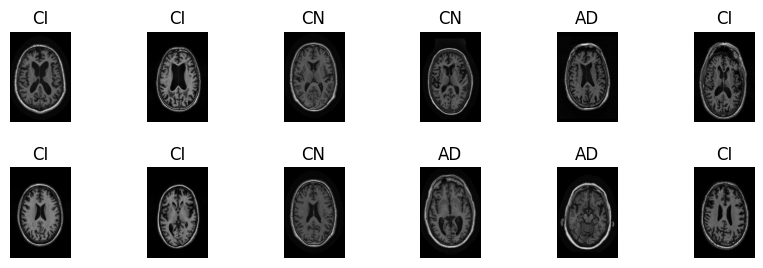

In [57]:
# Plots random 12 brain scans from dataset; just for something viusal
plt.figure(figsize=(10, 10)) # Creates a 10x10 size for the plot
for images, labels in train_dataset.take(1): # The loops the dataset and extracts batches of images with their corresponding labels
    for i in range(12): # Loops 12 times for 12 images
        ax = plt.subplot(6, 6, i + 1) # 6 rows 6 colums and selects current plot loctaion
        plt.imshow(images[i].numpy().astype("uint8")) # Image by converting it to numpy array and specifying its data type as integer unit8
        plt.title(class_names[labels[i]]) # Plots labels 
        plt.axis("off") # Removes Axis

plt.subplots_adjust(wspace=0.5, hspace=0.5) # Spaces images width and height from eachother

plt.show() # displays the plot


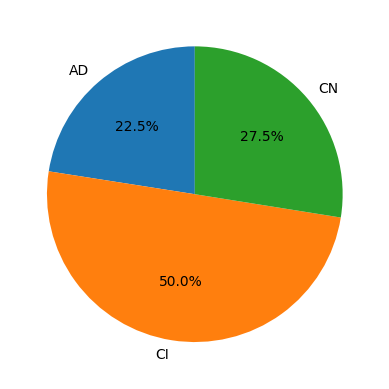

In [58]:

class_counts = [0] * len(class_names) #

for _, labels in train_dataset:
    for label in labels.numpy():
        class_counts[label] += 1


plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=90) 
#Class Counts:data,labels:Class Names,autopct='%1.1f%%':Format of the percentage display,startangle=90 specifies the angle at which the first slice starts

plt.title("") # Plot Title


plt.show() # Displays the plot

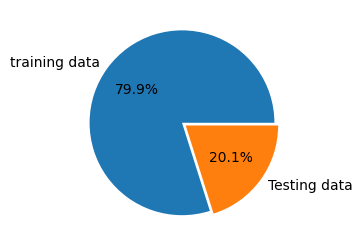

In [59]:
plt.figure(figsize=(3,3))
plt.pie(
    [len(train_dataset), len(validation_dataset)],
    labels=['training data','Testing data'],
    autopct='%.1f%%', explode=(0.05,0),
);

In [60]:
for image_batch, labels_batch in train_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(16, 256, 170, 3)
(16,)


In [61]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [62]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

num_classes = 3

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3,padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3,padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3,padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(
  optimizer= tf.keras.optimizers.Adam(learning_rate = 0.0001),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

model.build(input_shape=(None, image_height, image_width, 3))

In [63]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 256, 170, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 170, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 128, 85, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 85, 32)       4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 64, 42, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 42, 64)       

In [64]:
hist = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs= 5
)


Epoch 1/5


/home/jordano/.local/lib/python3.10/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


258/258 [==============================] - 33s 125ms/step - loss: 0.9157 - accuracy: 0.5698 - val_loss: 0.7037 - val_accuracy: 0.7340
Epoch 2/5
258/258 [==============================] - 23s 88ms/step - loss: 0.5281 - accuracy: 0.7973 - val_loss: 0.3942 - val_accuracy: 0.8650
Epoch 3/5
258/258 [==============================] - 23s 88ms/step - loss: 0.2389 - accuracy: 0.9246 - val_loss: 0.2536 - val_accuracy: 0.9107
Epoch 4/5
258/258 [==============================] - 23s 88ms/step - loss: 0.1046 - accuracy: 0.9758 - val_loss: 0.1685 - val_accuracy: 0.9359
Epoch 5/5
258/258 [==============================] - 23s 90ms/step - loss: 0.0501 - accuracy: 0.9908 - val_loss: 0.0745 - val_accuracy: 0.9777


In [65]:
# tf.keras.models.save_model(
#                             model,
#                            "Model_Alz.h5",
#                            include_optimizer= True ,
#                            save_format= "h5",
#                            )

model.save("model.keras")

In [66]:
model.evaluate(train_dataset)

  4/258 [..............................] - ETA: 5s - loss: 0.0390 - accuracy: 1.0000

258/258 [==============================] - 6s 21ms/step - loss: 0.0408 - accuracy: 0.9922


[0.04080130159854889, 0.9922405481338501]

In [67]:
model.evaluate(validation_dataset)

 1/65 [..............................] - ETA: 1s - loss: 0.0108 - accuracy: 1.0000

65/65 [==============================] - 1s 20ms/step - loss: 0.0745 - accuracy: 0.9777


[0.07450191676616669, 0.977669894695282]

In [68]:


testDataset = ["Alz_Datasets/Alz2/Axial/"]

testPaths = []
testLabels = []

for testDir in testDataset:
    for label in os.listdir(testDir):
        for image in os.listdir(os.path.join(testDir, label)):
            imagePath = os.path.join(testDir, label, image)
            testPaths.append(imagePath)
            testLabels.append(label)

testPaths, testLabels = shuffle(testPaths, testLabels)



1/1 [==============================] - 0s 16ms/step


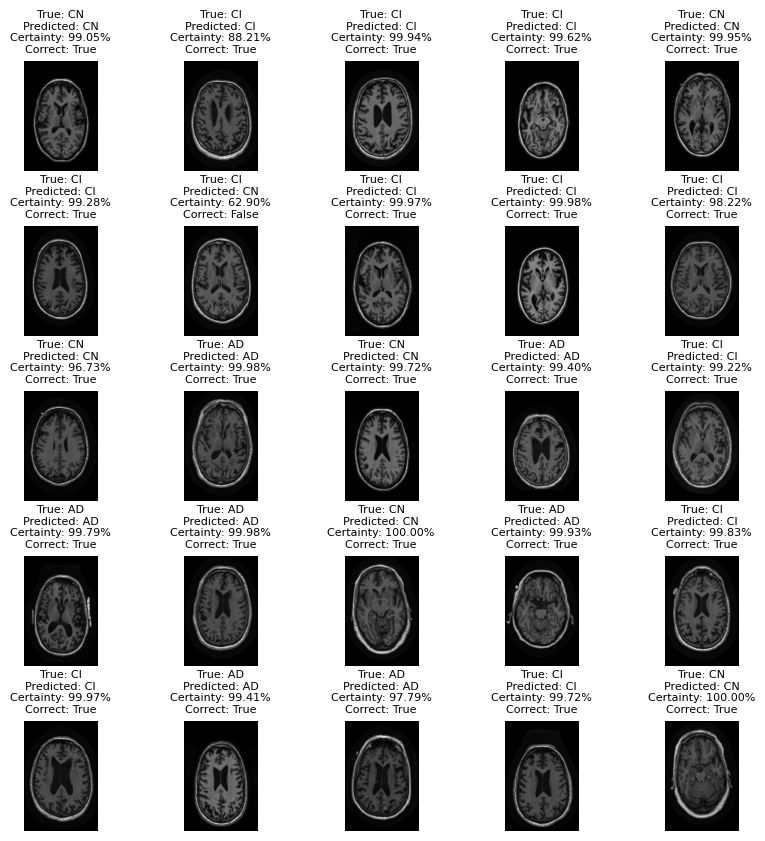

In [69]:

def predictAndPlot(model, paths, labels, n_samples=100):
    plt.figure(figsize=(10, 10))
    for i in range(min(n_samples, len(paths))):
        index = random.randint(0, len(paths)-1)
        image_path = paths[index]
        true_label = labels[index]
        
        image = load_img(image_path, target_size=(image_height, image_width))
        image_array = np.array([(image)])
        plt.subplots_adjust(hspace=0.5)

        prediction_probabilities = model.predict(image_array)[0]
        predicted_label_index = np.argmax(prediction_probabilities)
        predicted_label = class_names[predicted_label_index]
        certainty = prediction_probabilities[predicted_label_index] * 100
        correct = true_label == predicted_label
        
        plt.subplot(5, 5, i+1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f'True: {true_label}\nPredicted: {predicted_label}\nCertainty: {certainty:.2f}%\nCorrect: {correct}', fontsize=8)

predictAndPlot(model, testPaths, testLabels, n_samples=25)
plt.show()


1/1 [==============================] - 0s 84ms/step


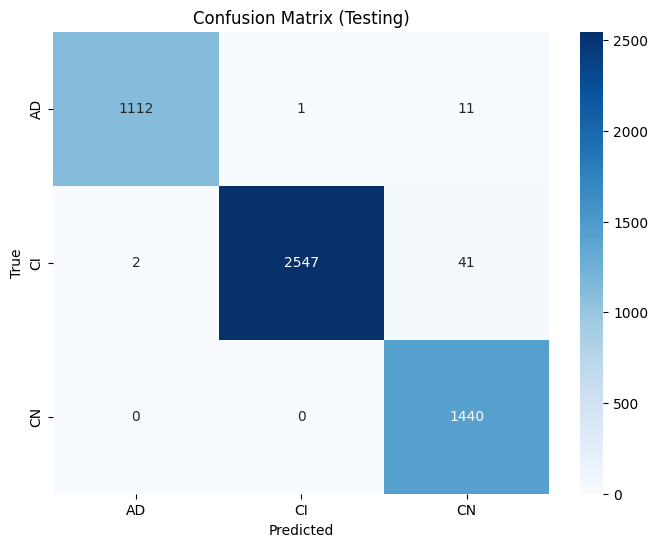

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Assuming `model`, `dataset`, and `class_names` are defined correctly
# You should replace `dataset` with your actual test data

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the dataset and make predictions
for images, labels_batch in dataset:
    predictions_batch = model.predict(images)
    predicted_labels_batch = np.argmax(predictions_batch, axis=1)
    
    true_labels.extend(labels_batch.numpy())
    predicted_labels.extend(predicted_labels_batch)

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate confusion matrix
confusion_matrix = tf.math.confusion_matrix(true_labels, predicted_labels, num_classes=len(class_names))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Testing)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


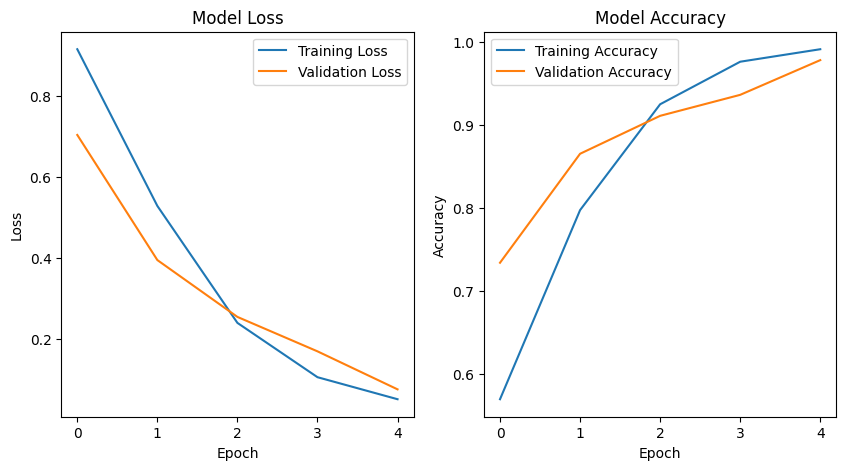

In [72]:

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()